# DeepAR-TFT Ensemble Forecasts

## Install packages and libraries

In [ ]:
!pip install gluonts==0.13.2 graphviz==0.8.4 lightning-utilities==0.9.0 matplotlib==3.7.1 numpy==1.24.4 optuna==3.2.0 pandas==1.5.3 pytorch-lightning==2.0.6   tqdm==4.65.0 xgboost==1.7.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: pydantic
    Found exist

In [ ]:
!pip install torch==1.11.0+cu115 torchvision==0.12+cu115 torchaudio==0.11+cu115 --extra-index-url https://download.pytorch.org/whl/cu115

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu115
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

## Import packages and libraries

In [ ]:
import xgboost as xgb
import torch
import numpy as np
import gluonts
import pandas as pd
import matplotlib.pyplot as pl
import gluonts
import numpy as np
import glob
import os

In [ ]:
from google.colab import drive # connecting to google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Data

In [ ]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
# Read the merged dataset
data = pd.read_csv('/content/drive/MyDrive/Laboratory/project/HS/Dataset/fatigueset/a_pp/merged_fatigue.csv', index_col='timestamp', parse_dates=True, decimal = '.')

In [ ]:
df_input = data.reset_index(drop=True).T.reset_index()

In [ ]:
ts_code = df_input["index"].astype('category').cat.codes.values

In [ ]:
#ratio
train_data = df_input.iloc[:, :128749].values
test_data = df_input.iloc[:, 128749:].values

In [ ]:
freq = '1S'  #set the frequency of time series data
start_train = pd.Timestamp(0.0)   #set the starting point of the training
start_test = pd.Timestamp(128749.0)  #set the starting point of the testing
prediction_length = 600  #set the prediction length

In [ ]:
# Create a ListDataset for each target variable
test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip([test_data[25, 1:], test_data[26, 1:]], ts_code[0:27].reshape(-1, 1))
], freq=freq)

## DeepAR (MODEL1)

###Load back trained DeepAR model

In [ ]:
from gluonts.model.predictor import Predictor
from pathlib import Path
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm.autonotebook import tqdm

In [ ]:
# Load the model from the path it was saved to
dir_path='/content/drive/MyDrive/Laboratory/project/HS/Code/Ensemble Model/DeepAR/deepar_model'
deepar_predictor = Predictor.deserialize(Path(dir_path))

In [ ]:
deepar_forecast, deepar_ts=make_evaluation_predictions(
    dataset=test_ds,
    predictor=deepar_predictor,
    num_samples=1000,
)

In [ ]:
print("Obtaining time series conditioning values ... ")
deepar_tss = list(tqdm(deepar_ts, total = len(test_data)))   #obtaining the list of time series conditioning values
print("Obtaining time series predictions ...")
deepar_forecast = list(tqdm(deepar_forecast, total = len(test_data)))  #obtaining the time series predictions

Obtaining time series conditioning values ... 


  0%|          | 0/27 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
deepar_forecast_np=np.array(deepar_forecast)
deepar_forecast_np.shape

(2,)

In [ ]:
df_deepar = pd.DataFrame(deepar_forecast_np)

In [ ]:
df_deepar

,0
0,gluonts.model.forecast.SampleForecast(info=Non...
1,gluonts.model.forecast.SampleForecast(info=Non...


In [ ]:
deepar_forecast= np.array(deepar_forecast).reshape(-1, 1)

## TFT (MODEL2)

###Load back trained TFT model

In [ ]:
# Import necessary libraries
from pathlib import Path

# Define the directory where the model is saved
dir_path = "/content/drive/MyDrive/Laboratory/project/HS/Code/Ensemble Model/TemporalFusionTransformer/tft_model"

# Load the saved predictor
tft_predictor= Predictor.deserialize(Path(dir_path))

In [ ]:
tft_forecast, tft_ts=make_evaluation_predictions(
    dataset=test_ds,
    predictor=tft_predictor,
    num_samples=1000,
)

In [ ]:
print("Obtaining time series conditioning values ... ")
tft_tss = list(tqdm(tft_ts, total = len(test_data)))   #obtaining the list of time series conditioning values
print("Obtaining time series predictions ...")
tft_forecast = list(tqdm(tft_forecast, total = len(test_data)))  #obtaining the time series predictions

Obtaining time series conditioning values ... 


  0%|          | 0/27 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
tft_forecast_np=np.array(tft_forecast)
tft_forecast_np.shape

(2,)

In [ ]:
df_tft = pd.DataFrame(tft_forecast_np)
df_tft

,0
0,"QuantileForecast(array([[ 1.1164391 , 1.08432..."
1,"QuantileForecast(array([[13.54999 , 13.527887..."


In [ ]:
tft_forecast = np.array(tft_forecast).reshape(-1, 1)

###Generate meta-features

In [ ]:
# Extract the mean of the samples from the DeepAR forecasts
deepar_predictions = np.array([forecast[0].samples.mean(axis=0) for forecast in deepar_forecast])

# Extract the mean of the samples from the TFT forecasts
tft_predictions = np.array([forecast[0].quantile(0.5) for forecast in tft_forecast])

In [ ]:
deepar_predictions.shape

(2, 200)

In [ ]:
tft_predictions.shape

(2, 200)

In [ ]:
ensemble_features1=np.stack((deepar_predictions[0], tft_predictions[0]), axis=1)

In [ ]:
ensemble_features2=np.stack((deepar_predictions[0], tft_predictions[0]), axis=1)

In [ ]:
ensemble_features1.T.shape
ensemble_features1 = ensemble_features1.T

In [ ]:
ensemble_features2.T.shape
ensemble_features2 = ensemble_features2.T

##XGBoost (Meta-Learner)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Extract the target values from the test dataset
target_values = [entry[FieldName.TARGET] for entry in test_ds]

In [ ]:
target_values_array = np.array(target_values)

In [ ]:
target_values_array.shape

(2, 32187)

In [ ]:
df = pd.DataFrame(target_values_array)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,32177,32178,32179,32180,32181,32182,32183,32184,32185,32186
0,4.549581,4.547002,4.544426,4.541852,4.539282,4.536713,4.534147,4.531584,4.529023,4.526465,...,-0.369868,-0.377856,-0.385846,-0.393838,-0.401830,-0.409824,-0.417819,-0.425815,-0.433813,-0.441812
1,4.378766,4.373741,4.368721,4.363704,4.358691,4.353683,4.348678,4.343677,4.338680,4.333687,...,12.520160,12.514612,12.509063,12.503512,12.497961,12.492409,12.486856,12.481301,12.475746,12.470190


###Train XGBoost meta-learner

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
X1 = ensemble_features1.T
X2 = ensemble_features2.T

In [ ]:
X1.shape

(200, 2)

In [ ]:
PF=target_values_array[0]

In [ ]:
PF.shape

(32187,)

In [ ]:
MF=target_values_array[1]

In [ ]:
MF.shape

(32187,)

In [ ]:
# Define a function to split the data
def split_data(X, y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    test_size = int(len(X) * test_size)
    train_indices, test_indices = indices[:-test_size], indices[-test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

In [ ]:
# Split the data
X1_train, X1_test, y1_train, y1_test = split_data(X1, PF[:200], test_size=0.2, random_state=42)

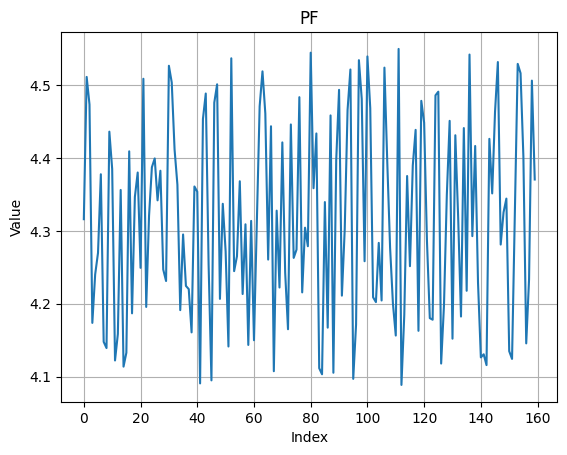

In [ ]:
import matplotlib.pyplot as plt
# Plot the first 200 elements
plt.plot(y1_train)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('PF')
plt.grid(True)
plt.show()

In [ ]:
# Split the data
X2_train, X2_test, y2_train, y2_test = split_data(X2, MF[:200], test_size=0.2, random_state=42)

In [ ]:
dtrain1 = xgb.DMatrix(X1_train, label=y1_train)
dtest1 = xgb.DMatrix(X1_test, label=y1_test)

In [ ]:
dtrain2 = xgb.DMatrix(X2_train, label=y2_train)
dtest2 = xgb.DMatrix(X2_test, label=y2_test)

In [ ]:
# Define parameters
params = {
            'max_depth': 3,  # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
            'eta': 0.3,  # Learning rate
            'objective': 'reg:squarederror',  # Loss function to minimize
            'eval_metric': 'rmse',  # Evaluation metric for validation data
            'verbosity':1,
            'subsample':0.2, #from 0 to 1, randomly sample 20% of the training data prior to growing trees
            'lambda':1,
            'alpha':1,
            'tree_method':'auto',
            'predictor':'auto',
            'seed':42,
}

In [ ]:
num_rounds = 100
evallist1 = [(dtrain1, 'train'), (dtest1, 'eval')]
evallist2 = [(dtrain2, 'train'), (dtest2, 'eval')]

In [ ]:
import matplotlib.pyplot as plt

RMSE: 3.806765556335449
MSE: 14.491464614868164
[0]	train-rmse:2.71748	eval-rmse:2.71060
RMSE: 2.7106034755706787
MSE: 7.3473711013793945
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
RMSE: 1.9371156692504883
MSE: 3.7524170875549316
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
RMSE: 1.3842307329177856
MSE: 1.9160947799682617
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
RMSE: 0.9980907440185547
MSE: 0.9961851835250854
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
RMSE: 0.7227141857147217
MSE: 0.5223158001899719
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/l

RMSE: 0.22356314957141876
MSE: 0.04998048394918442
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
RMSE: 0.1766418218612671
MSE: 0.03120233491063118
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
RMSE: 0.14349035918712616
MSE: 0.0205

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


RMSE: 0.0785294696688652
MSE: 0.006166878156363964
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
RMSE: 0.07295916974544525
MSE: 0.005323040299117565
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rms

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
RMSE: 0.06965596973896027
MSE: 0.004851954057812691
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
RMSE: 0.06206649914383888
MSE: 0.0038522505201399326
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
RMSE: 0.060619886964559555
MSE: 0.0036747704725712538
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rm

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


RMSE: 0.054551221430301666
MSE: 0.002975835930556059
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
RMSE: 0.054551221430301666
MSE: 0.002975835930556059
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
RMSE: 0.054551221430301666
MSE: 0.002975835930556059
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
RMSE: 0.054551221430301666
MSE: 0.002975835930556059
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rms

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
RMSE: 0.054551221430301666
MSE: 0.002975835930556059
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rm

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
RMSE: 0.053518254309892654
MSE: 0.0028642036486417055
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.054

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.0545

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



MSE: 0.0028642036486417055
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
RMSE: 0.05247975513339043
MSE: 0.002754124579951167
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
RMSE: 0.05167654529213905
MSE: 0.0026704655028879642
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
RMSE: 0.05167654529213905
MSE: 0.0026704655028879642
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
RMSE: 0.05167654529213905
MSE: 0.0026704655028879642
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
RMSE: 0.05167654529213905
MSE: 0.0026704655028879642
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
RMSE: 0.0505983904004097
MSE: 0.0025601971428841352
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


RMSE: 0.05031197518110275
MSE: 0.002531294710934162
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
RMSE: 0.05031197518110275
MSE: 0.002531294710934162
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:0.07853
[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
RMSE: 0.05031197518110275
MSE: 0.002531294710934162
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rmse:0.09512
[13]	train-rmse:0.09214	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
RMSE: 0.050054676830768585
MSE: 0.0025054707657545805
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rmse:0.11419
[12]	train-rmse:0.10797	eval-rms

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
RMSE: 0.050054676830768585
MSE: 0.0025054707657545805
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rmse:0.14349
[11]	train-rmse:0.12821	eval-rms

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
RMSE: 0.050054676830768585
MSE: 0.0025054707657545805
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
RMSE: 0.050054676830768585
MSE: 0.0025054707657545805
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eva

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
RMSE: 0.050054676830768585
MSE: 0.0025054707657545805
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	eval-rmse:1.93712
[2]	train-rmse:1.39191	eval-rmse:1.38423
[3]	train-rmse:1.00639	eval-rmse:0.99809
[4]	train-rmse:0.73185	eval-rmse:0.72271
[5]	train-rmse:0.54417	eval-rmse:0.53400
[6]	train-rmse:0.40736	eval-rmse:0.39585
[7]	train-rmse:0.30719	eval-rmse:0.29433
[8]	train-rmse:0.23806	eval-rmse:0.22356
[9]	train-rmse:0.19076	eval-rmse:0.17664
[10]	train-rmse:0.15783	eval-rm

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
RMSE: 0.050054676830768585
MSE: 0.0025054707657545805
[0]	train-rmse:2.71748	eval-rmse:2.71060
[1]	train-rmse:1.94433	

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:0.05005
[61]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:0.05005
[61]	train-rmse:0.05897	eval-rmse:0.05005
[62]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:0.05005
[61]	train-rmse:0.05897	eval-rmse:0.05005
[62]	train-rmse:0.05897	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:0.05005
[61]	train-rmse:0.05897	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:0.05005
[61]	train-rmse:0.05897	eval-rmse:0.05005
[62]	train-rmse:0.05897	eval-rmse:0.05005
[63]	train-rmse:0.05897	eval-rmse:0.05005
[64]	train-rmse:0.05897	eval-rmse:0.05005
[65]	train-rmse:0.05897	eval-rmse:0.05005
[66]	train-rmse:0.05897	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:0.05005
[57]	train-rmse:0.05897	eval-rmse:0.05005
[58]	train-rmse:0.05897	eval-rmse:0.05005
[59]	train-rmse:0.05897	eval-rmse:0.05005
[60]	train-rmse:0.05897	eval-rmse:0.05005
[61]	train-rmse:0.05897	eval-rmse:0.05005
[62]	train-rmse:0.05897	eval-rmse:0.05005
[63]	train-rmse:0.05897	eval-rmse:0.05005
[64]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:0.05168
[48]	train-rmse:0.06104	eval-rmse:0.05168
[49]	train-rmse:0.06104	eval-rmse:0.05168
[50]	train-rmse:0.05952	eval-rmse:0.05060
[51]	train-rmse:0.05924	eval-rmse:0.05031
[52]	train-rmse:0.05924	eval-rmse:0.05031
[53]	train-rmse:0.05924	eval-rmse:0.05031
[54]	train-rmse:0.05897	eval-rmse:0.05005
[55]	train-rmse:0.05897	eval-rmse:0.05005
[56]	train-rmse:0.05897	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:0.05352
[38]	train-rmse:0.06343	eval-rmse:0.05352
[39]	train-rmse:0.06343	eval-rmse:0.05352
[40]	train-rmse:0.06343	eval-rmse:0.05352
[41]	train-rmse:0.06343	eval-rmse:0.05352
[42]	train-rmse:0.06343	eval-rmse:0.05352
[43]	train-rmse:0.06343	eval-rmse:0.05352
[44]	train-rmse:0.06343	eval-rmse:0.05352
[45]	train-rmse:0.06201	eval-rmse:0.05248
[46]	train-rmse:0.06104	eval-rmse:0.05168
[47]	train-rmse:0.06104	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[14]	train-rmse:0.08680	eval-rmse:0.07296
[15]	train-rmse:0.08445	eval-rmse:0.07052
[16]	train-rmse:0.08362	eval-rmse:0.06966
[17]	train-rmse:0.08362	eval-rmse:0.06966
[18]	train-rmse:0.08053	eval-rmse:0.06710
[19]	train-rmse:0.08053	eval-rmse:0.06710
[20]	train-rmse:0.07315	eval-rmse:0.06207
[21]	train-rmse:0.07315	eval-rmse:0.06207
[22]	train-rmse:0.07113	eval-rmse:0.06063
[23]	train-rmse:0.07112	eval-rmse:0.06062
[24]	train-rmse:0.06734	eval-rmse:0.05757
[25]	train-rmse:0.06444	eval-rmse:0.05455
[26]	train-rmse:0.06444	eval-rmse:0.05455
[27]	train-rmse:0.06444	eval-rmse:0.05455
[28]	train-rmse:0.06444	eval-rmse:0.05455
[29]	train-rmse:0.06444	eval-rmse:0.05455
[30]	train-rmse:0.06444	eval-rmse:0.05455
[31]	train-rmse:0.06444	eval-rmse:0.05455
[32]	train-rmse:0.06444	eval-rmse:0.05455
[33]	train-rmse:0.06444	eval-rmse:0.05455
[34]	train-rmse:0.06444	eval-rmse:0.05455
[35]	train-rmse:0.06343	eval-rmse:0.05352
[36]	train-rmse:0.06343	eval-rmse:0.05352
[37]	train-rmse:0.06343	eval-rmse:

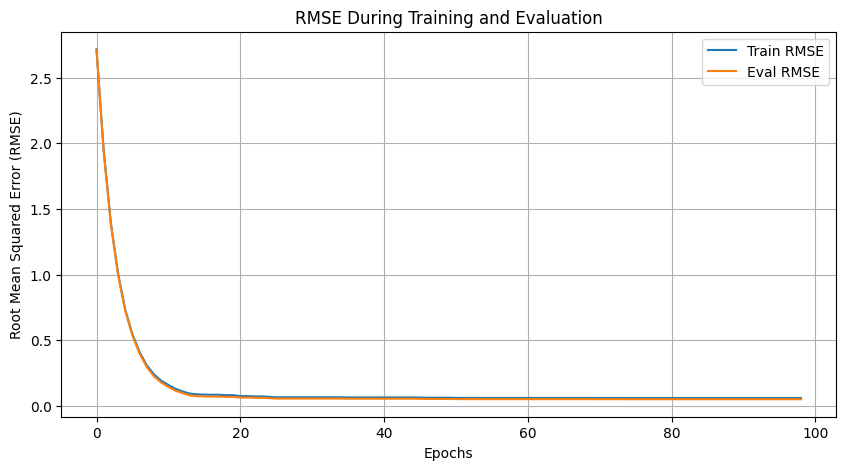

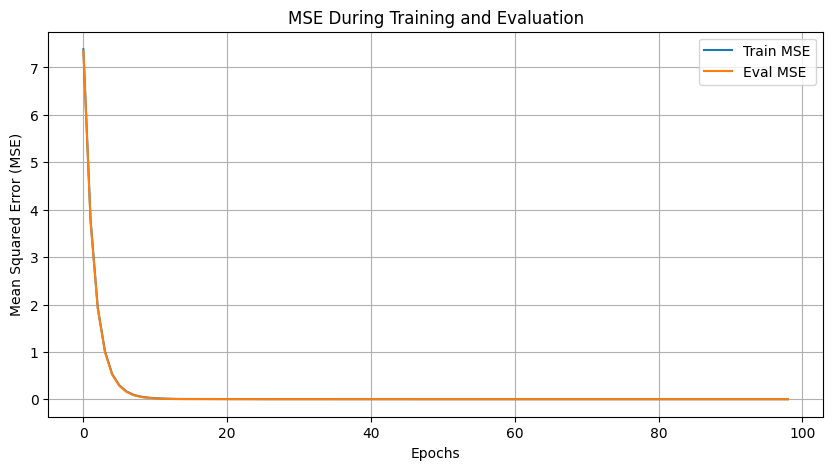

In [ ]:
evals_result1 = {}
evallist1 = [(dtrain1, 'train'), (dtest1, 'eval')]


# Train the model
for epochs in range(num_rounds):

    bst_PF = xgb.train(params, dtrain1, epochs, evallist1, evals_result=evals_result1)

    # Make predictions on the test set
    y1_pred = bst_PF.predict(dtest1)

    rmse = mean_squared_error(y1_test, y1_pred, squared=False)
    print(f'RMSE: {rmse}')
    mse = mean_squared_error(y1_test, y1_pred, squared=True)
    print(f'MSE: {mse}')

 # Extract RMSE and MSE
train_rmse1 = evals_result1['train']['rmse']
eval_rmse1 = evals_result1['eval']['rmse']

    # Convert RMSE to MSE (optional)
train_mse1 = [x**2 for x in train_rmse1]
eval_mse1 = [x**2 for x in eval_rmse1]

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(train_rmse1, label='Train RMSE')
plt.plot(eval_rmse1, label='Eval RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.title('RMSE During Training and Evaluation')
plt.grid(True)
plt.show()


# Plot MSE (optional)
plt.figure(figsize=(10, 5))
plt.plot(train_mse1, label='Train MSE')
plt.plot(eval_mse1, label='Eval MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.title('MSE During Training and Evaluation')
plt.grid(True)
plt.show()

bst_PF.save_model(f'/content/drive/MyDrive/Laboratory/project/HS/Code/Ensemble Model/xgboost_model_PF.model')

[0]	train-rmse:2.45281	eval-rmse:2.43758
[1]	train-rmse:1.76563	eval-rmse:1.74898
[2]	train-rmse:1.28253	eval-rmse:1.26400
[3]	train-rmse:0.94928	eval-rmse:0.92837
[4]	train-rmse:0.71491	eval-rmse:0.69106
[5]	train-rmse:0.54403	eval-rmse:0.52308
[6]	train-rmse:0.42594	eval-rmse:0.40122
[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:0.06014
[74]	train-rmse:0.07362	eval-rmse:0.05981
[75]	train-rmse:0.07362	eval-rmse:0.05981
[76]	train-rmse:0.07362	eval-rmse:0.05981
[77]	train-rmse:0.07362	eval-rmse:0.05981
[78]	train-rmse:0.07362	eval-rmse:0.05981
[79]	train-rmse:0.07362	eval-rmse:0.05981
[80]	train-rmse:0.07362	eval-rmse:0.05981
[81]	train-rmse:0.07362	eval-rmse:0.05981
[82]	train-rmse:0.07362	eval-rmse:0.05981
[83]	train-rmse:0.07362	eval-rmse:0.05981
[84]	train-rmse:0.07362	eval-rmse:0.05981
[85]	train-rmse:0.07362	eval-rmse:0.05981
[86]	train-rmse:0.07362	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:0.06014
[74]	train-rmse:0.07362	eval-rmse:0.05981
[75]	train-rmse:0.07362	eval-rmse:0.05981
[76]	train-rmse:0.07362	eval-rmse:0.05981
[77]	train-rmse:0.07362	eval-rmse:0.05981
[78]	train-rmse:0.07362	eval-rmse:0.05981
[79]	train-rmse:0.07362	eval-rmse:0.05981
[80]	train-rmse:0.07362	eval-rmse:0.05981
[81]	train-rmse:0.07362	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:0.06014
[74]	train-rmse:0.07362	eval-rmse:0.05981
[75]	train-rmse:0.07362	eval-rmse:0.05981
[76]	train-rmse:0.07362	eval-rmse:0.05981
[77]	train-rmse:0.07362	eval-rmse:0.05981
[78]	train-rmse:0.07362	eval-rmse:0.05981
[79]	train-rmse:0.07362	eval-rmse:0.05981
[80]	train-rmse:0.07362	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:0.06014
[74]	train-rmse:0.07362	eval-rmse:0.05981
[75]	train-rmse:0.07362	eval-rmse:0.05981
[76]	train-rmse:0.07362	eval-rmse:0.05981
[77]	train-rmse:0.07362	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:0.06014
[74]	train-rmse:0.07362	eval-rmse:0.05981
[75]	train-rmse:0.07362	eval-rmse:0.05981
[76]	train-rmse:0.07362	eval-rmse:0.05981
[77]	train-rmse:0.07362	eval-rmse:0.05981
[78]	train-rmse:0.07362	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:0.06099
[67]	train-rmse:0.07440	eval-rmse:0.06099
[68]	train-rmse:0.07440	eval-rmse:0.06099
[69]	train-rmse:0.07440	eval-rmse:0.06099
[70]	train-rmse:0.07439	eval-rmse:0.06092
[71]	train-rmse:0.07439	eval-rmse:0.06092
[72]	train-rmse:0.07404	eval-rmse:0.06014
[73]	train-rmse:0.07404	eval-rmse:0.06014
[74]	train-rmse:0.07362	eval-rmse:0.05981
[75]	train-rmse:0.07362	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[5]	train-rmse:0.54403	eval-rmse:0.52308
[6]	train-rmse:0.42594	eval-rmse:0.40122
[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.067

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[5]	train-rmse:0.54403	eval-rmse:0.52308
[6]	train-rmse:0.42594	eval-rmse:0.40122
[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.067

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	train-rmse:0.71491	eval-rmse:0.69106
[5]	train-rmse:0.54403	eval-rmse:0.52308
[6]	train-rmse:0.42594	eval-rmse:0.40122
[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.0678

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:0.06099
[62]	train-rmse:0.07440	eval-rmse:0.06099
[63]	train-rmse:0.07440	eval-rmse:0.06099
[64]	train-rmse:0.07440	eval-rmse:0.06099
[65]	train-rmse:0.07440	eval-rmse:0.06099
[66]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[3]	train-rmse:0.94928	eval-rmse:0.92837
[4]	train-rmse:0.71491	eval-rmse:0.69106
[5]	train-rmse:0.54403	eval-rmse:0.52308
[6]	train-rmse:0.42594	eval-rmse:0.40122
[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.0

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-rmse:1.76563	eval-rmse:1.74898
[2]	train-rmse:1.28253	eval-rmse:1.26400
[3]	train-rmse:0.94928	eval-rmse:0.92837
[4]	train-rmse:0.71491	eval-rmse:0.69106
[5]	train-rmse:0.54403	eval-rmse:0.52308
[6]	train-rmse:0.42594	eval-rmse:0.40122
[7]	train-rmse:0.32083	eval-rmse:0.29433
[8]	train-rmse:0.25612	eval-rmse:0.23239
[9]	train-rmse:0.20820	eval-rmse:0.18101
[10]	train-rmse:0.17092	eval-rmse:0.15246
[11]	train-rmse:0.14050	eval-rmse:0.12450
[12]	train-rmse:0.12425	eval-rmse:0.11425
[13]	train-rmse:0.10674	eval-rmse:0.09386
[14]	train-rmse:0.10128	eval-rmse:0.08718
[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[15]	train-rmse:0.09985	eval-rmse:0.08550
[16]	train-rmse:0.09801	eval-rmse:0.08317
[17]	train-rmse:0.09801	eval-rmse:0.08317
[18]	train-rmse:0.09375	eval-rmse:0.07954
[19]	train-rmse:0.09375	eval-rmse:0.07954
[20]	train-rmse:0.08662	eval-rmse:0.07444
[21]	train-rmse:0.08662	eval-rmse:0.07444
[22]	train-rmse:0.08528	eval-rmse:0.07294
[23]	train-rmse:0.08528	eval-rmse:0.07294
[24]	train-rmse:0.08323	eval-rmse:0.07043
[25]	train-rmse:0.07967	eval-rmse:0.06782
[26]	train-rmse:0.07967	eval-rmse:0.06782
[27]	train-rmse:0.07967	eval-rmse:0.06782
[28]	train-rmse:0.07967	eval-rmse:0.06782
[29]	train-rmse:0.07967	eval-rmse:0.06782
[30]	train-rmse:0.07967	eval-rmse:0.06782
[31]	train-rmse:0.07906	eval-rmse:0.06689
[32]	train-rmse:0.07906	eval-rmse:0.06689
[33]	train-rmse:0.07870	eval-rmse:0.06633
[34]	train-rmse:0.07870	eval-rmse:0.06633
[35]	train-rmse:0.07782	eval-rmse:0.06494
[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[36]	train-rmse:0.07782	eval-rmse:0.06494
[37]	train-rmse:0.07782	eval-rmse:0.06494
[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-rmse:0.07782	eval-rmse:0.06494
[39]	train-rmse:0.07782	eval-rmse:0.06494
[40]	train-rmse:0.07782	eval-rmse:0.06494
[41]	train-rmse:0.07782	eval-rmse:0.06494
[42]	train-rmse:0.07777	eval-rmse:0.06485
[43]	train-rmse:0.07777	eval-rmse:0.06485
[44]	train-rmse:0.07777	eval-rmse:0.06485
[45]	train-rmse:0.07740	eval-rmse:0.06431
[46]	train-rmse:0.07701	eval-rmse:0.06372
[47]	train-rmse:0.07701	eval-rmse:0.06372
[48]	train-rmse:0.07701	eval-rmse:0.06372
[49]	train-rmse:0.07701	eval-rmse:0.06372
[50]	train-rmse:0.07500	eval-rmse:0.06217
[51]	train-rmse:0.07449	eval-rmse:0.06116
[52]	train-rmse:0.07449	eval-rmse:0.06116
[53]	train-rmse:0.07449	eval-rmse:0.06116
[54]	train-rmse:0.07440	eval-rmse:0.06099
[55]	train-rmse:0.07440	eval-rmse:0.06099
[56]	train-rmse:0.07440	eval-rmse:0.06099
[57]	train-rmse:0.07440	eval-rmse:0.06099
[58]	train-rmse:0.07440	eval-rmse:0.06099
[59]	train-rmse:0.07440	eval-rmse:0.06099
[60]	train-rmse:0.07440	eval-rmse:0.06099
[61]	train-rmse:0.07440	eval-rmse:

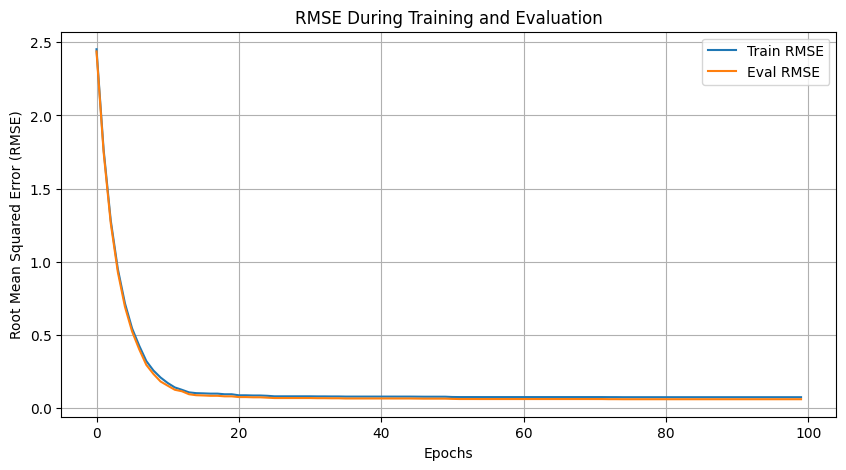

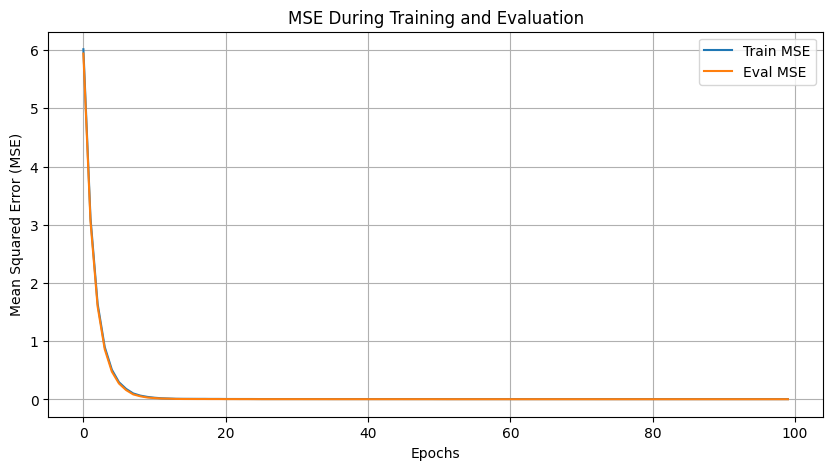

In [ ]:
evals_result2 = {}
evallist2 = [(dtrain2, 'train'), (dtest2, 'eval')]

# Train the model
for epochs in range(num_rounds):
    eval_result2 = {}

    bst_MF = xgb.train(params, dtrain2, num_rounds, evallist2, evals_result=evals_result2)


    # Make predictions on the test set
    y2_pred = bst_MF.predict(dtest2)

    # Calculate RMSE directly
    rmse = mean_squared_error(y2_test, y2_pred, squared=False)
    print(f'RMSE: {rmse}')

    # Calculate MSE and then take the square root to get RMSE
    mse = mean_squared_error(y2_test, y2_pred, squared=True)
    print(f'MSE: {mse}')
    # rmse_calculated = np.sqrt(mse)
    # print(f'RMSE (calculated from MSE): {rmse_calculated}')

# Extract RMSE and MSE
train_rmse2 = evals_result2['train']['rmse']
eval_rmse2 = evals_result2['eval']['rmse']

    # Convert RMSE to MSE (optional)
train_mse2 = [x**2 for x in train_rmse2]
eval_mse2 = [x**2 for x in eval_rmse2]


# Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(train_rmse2, label='Train RMSE')
plt.plot(eval_rmse2, label='Eval RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.title('RMSE During Training and Evaluation')
plt.grid(True)
plt.show()


# Plot MSE (optional)
plt.figure(figsize=(10, 5))
plt.plot(train_mse2, label='Train MSE')
plt.plot(eval_mse2, label='Eval MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.title('MSE During Training and Evaluation')
plt.grid(True)
plt.show()


bst_MF.save_model(f'/content/drive/MyDrive/Laboratory/project/HS/Code/Ensemble Model/xgboost_model_MF.model')

In [ ]:
#Load back XGBooster model later
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('model.bin')  # load data

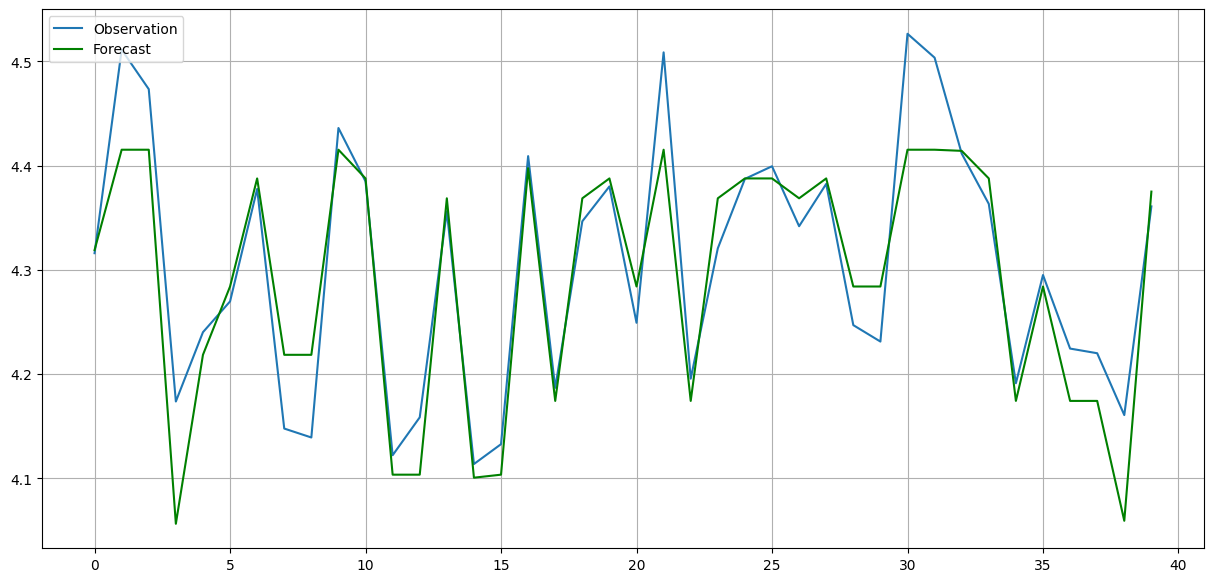

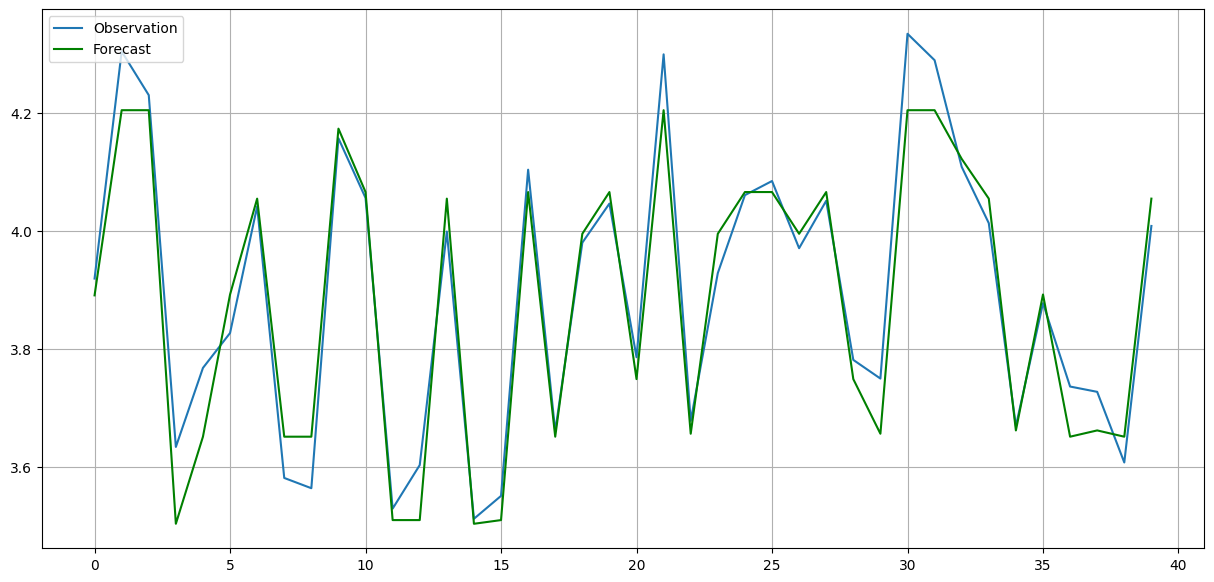

In [ ]:
def plot_xgboost_forecasts(ts_entry, forecast_entry, plot_length):
    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax, label="Observation")
    ax.plot(forecast_entry[-plot_length:], label="Forecast", color='g')

    plt.grid(which="both")
    plt.legend(loc="upper left")
    plt.show()

# Assuming y_test is your actual test data and predictions are the forecasts from XGBoost
ts_entry1 = pd.Series(y1_test.flatten())  # Convert to a Pandas Series if not already
forecast_entry1 = pd.Series(y1_pred.flatten())  # Convert predictions to a Pandas Series
ts_entry2 = pd.Series(y2_test.flatten())  # Convert to a Pandas Series if not already
forecast_entry2 = pd.Series(y2_pred.flatten())  # Convert predictions to a Pandas Series

plot_length =200 # Define the number of time steps to plot
plot_xgboost_forecasts(ts_entry1, forecast_entry1, plot_length)
plot_xgboost_forecasts(ts_entry2, forecast_entry2, plot_length)

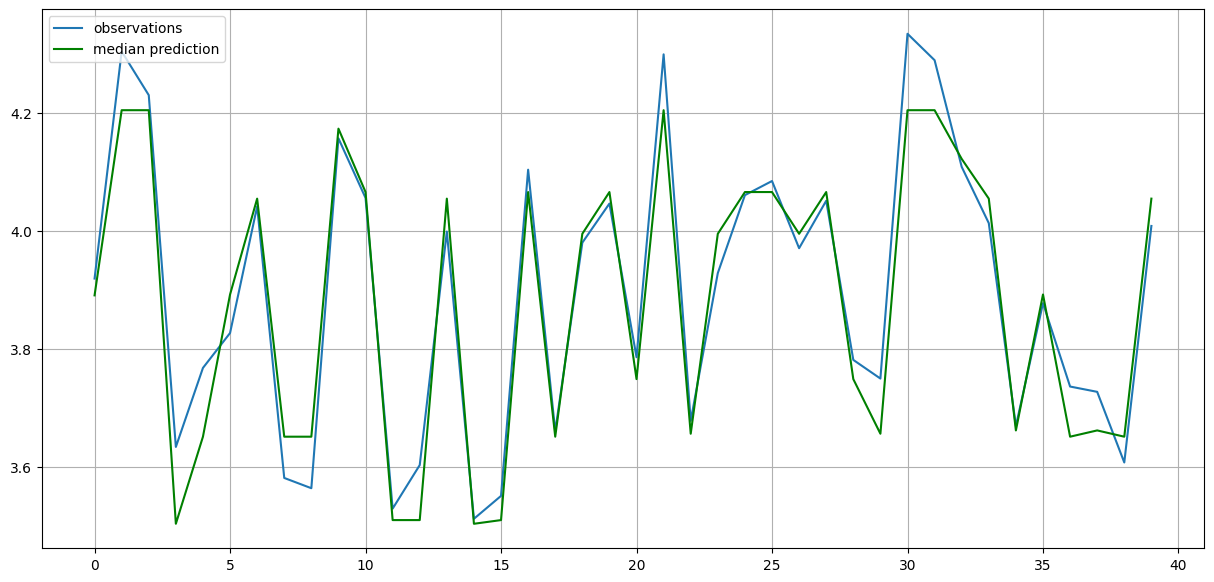

In [ ]:
def plot_prob_forecasts1(ts_entry, forecast_entry, prediction_length):   #time series entry and forecast entry
    plot_length = prediction_length
    prediction_intervals = (0.90, 0.95)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(color='g')

    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts1(ts_entry2,forecast_entry2,len(y2_pred))

###Hyperparameter tuning

In [ ]:
!pip install optuna

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Define objective function for Optuna
def objective(trial):
    param = {
        'silent': 1,
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }

    bst = xgb.train(param, xgb.DMatrix(X_train, label=y_train))
    preds = bst.predict(xgb.DMatrix(X_test))
    error = mean_squared_error(y_test, preds)

    return error

In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

In [ ]:
# Print the result
trial = study.best_trial
print('MSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))